In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [269]:

df = pd.read_excel('Bjorge_et_al_catchlogbook_whaling_weather_data_1932-63_data_publication (1).csv')

print(df.head())

new_data = 'Divine_et_al_data_publication_Antarctic_logbooks_v2_Nov2023_final (1).xlsx'
new_data_df = pd.read_excel(new_data)

       Ship       date   Latitude  Longitude  Temp (air)  Temp (sea)    mBar  \
0  Solglimt 1932-10-23 -54.100000   5.100000         NaN         NaN   979.0   
1  Solglimt 1932-10-24 -53.583333   4.800000         NaN         NaN   986.0   
2  Solglimt 1932-10-25 -53.300000   4.000000         NaN         NaN   993.0   
3  Solglimt 1932-10-26 -53.616667   3.600000         NaN         NaN   994.0   
4  Solglimt 1932-10-27 -53.400000   3.333333         NaN         NaN  1018.0   

  Weather Wind  Strength (Wind)  ...  Humpback Whale Sperm Whales  Sei Whale  \
0       l    N              3.0  ...             0.0          NaN        NaN   
1       d   NW              4.0  ...             0.0          NaN        NaN   
2       d   NW              4.0  ...             0.0          NaN        NaN   
3       c  WSW              3.0  ...             0.0          NaN        NaN   
4       d  WNW              2.0  ...             0.0          NaN        NaN   

   Unnamed: 17  Unnamed: 18  Unnamed: 

      year  Temp (air), C
2   1934.0           -0.6
3   1934.0           -2.2
4   1934.0           -2.2
5   1934.0           -2.2
6   1934.0           -1.1
7   1934.0            0.0
8   1934.0           -0.6
9   1934.0           -1.1
10  1934.0           -0.6
11  1934.0            0.0


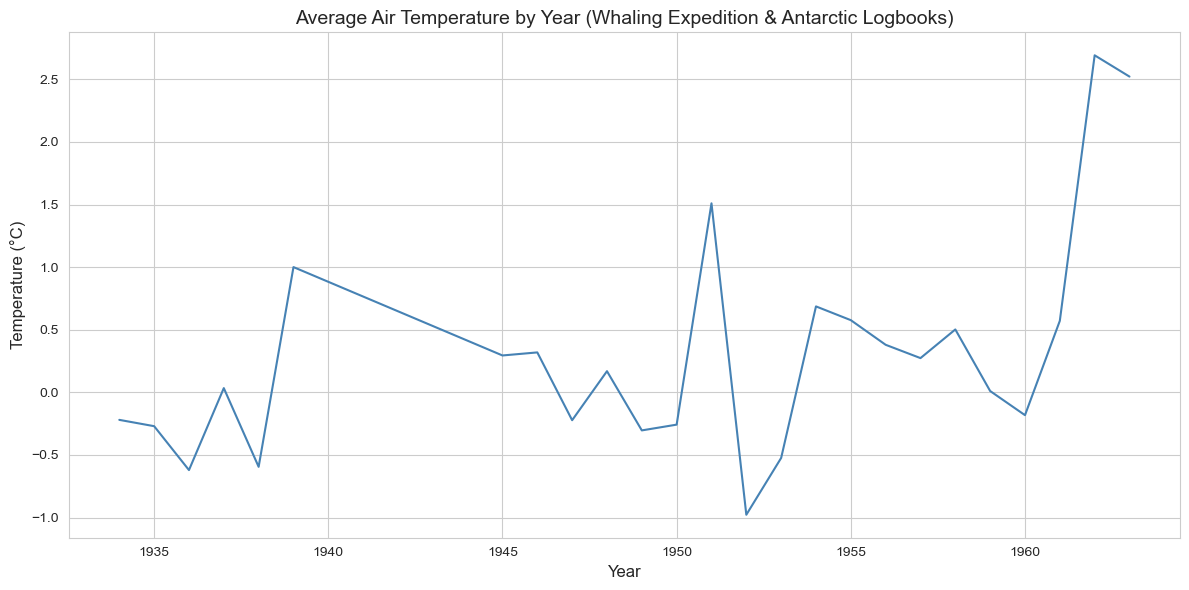

In [636]:
# Convert date to datetime and extract year/month
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filter out rows with missing temperature data
temp_df = df[df['Temp (air)'].notna()].copy()

# Extract numeric temperature values from 'Weather conditions' column
new_data_df['Temp (air), C'] = pd.to_numeric(new_data_df['Weather conditions'], errors='coerce')

# Extract year and month from the 'Date' column
new_data_df['date'] = pd.to_datetime(new_data_df['Date'], errors='coerce', dayfirst=True)  # Specify dayfirst=True to avoid warning
new_data_df['year'] = new_data_df['date'].dt.year
new_data_df['month'] = new_data_df['date'].dt.month

temp_df = df[df['Temp (air)'].notna()].copy()

# Filter out rows with missing temperature data
new_data_df_filtered = new_data_df.dropna(subset=['Temp (air), C'])

# Apply forward-fill for the missing data (fill the initial years)
new_data_df_filtered.loc[:, 'Temp (air), C'] = new_data_df_filtered['Temp (air), C'].ffill()

# Interpolate missing values for the middle of the data
new_data_df_filtered.loc[:, 'Temp (air), C'] = new_data_df_filtered['Temp (air), C'].interpolate(method='linear')

# Apply backward-fill for any remaining missing values (e.g., if last year has missing data)
new_data_df_filtered.loc[:, 'Temp (air), C'] = new_data_df_filtered['Temp (air), C'].bfill()

# Now, check the cleaned dataset to ensure it contains the necessary columns
print(new_data_df_filtered[['year', 'Temp (air), C']].head(10))  # Show the first 10 rows after cleaning

# Combine both datasets into one unified dataset
whaling_data = temp_df[['year', 'Temp (air)']].copy()  
whaling_data['source'] = 'Whaling Expedition'  

antarctic_data = new_data_df_filtered[['year', 'Temp (air), C']].copy()  
antarctic_data['source'] = 'Antarctic Logbooks'  
antarctic_data = antarctic_data.rename(columns={'Temp (air), C': 'Temp (air)'})  # Rename to match the whaling data column name


combined_data = pd.concat([whaling_data, antarctic_data], ignore_index=True)

plt.figure(figsize=(12, 6))

# Plot the combined dataset
sns.lineplot(data=combined_data, x='year', y='Temp (air)', estimator='mean', errorbar=None, color='steelblue')

# Add title and labels
plt.title('Average Air Temperature by Year (Whaling Expedition & Antarctic Logbooks)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)

# Add gridlines for better readability
plt.grid(True)

plt.tight_layout()
plt.show()



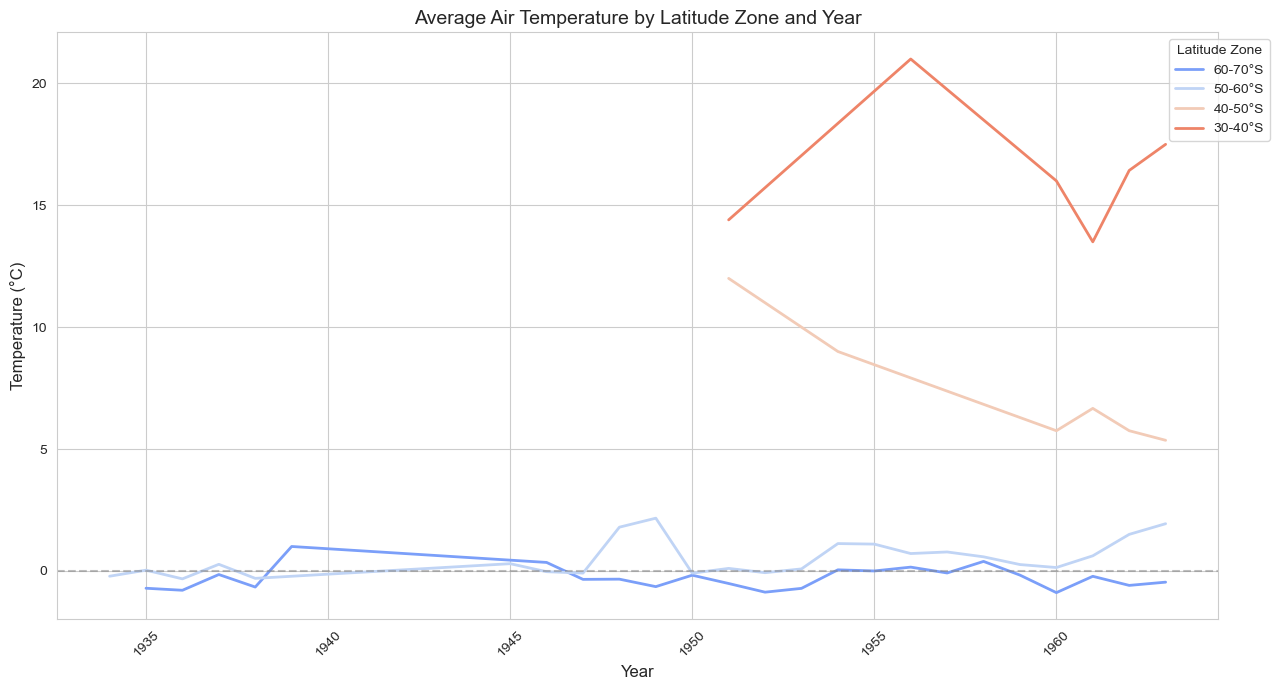

In [654]:


# Process the whaling data 
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filter out rows with missing temperature data
temp_df = df[df['Temp (air)'].notna()].copy()

# Process the Antarctic dat
# identify the latitude column
latitude_col = None
for col in new_data_df.columns:
    if 'lat' in col.lower():
        latitude_col = col
        break

if latitude_col is None:
    raise ValueError("No latitude column found in Antarctic data. Available columns:", new_data_df.columns.tolist())

# Process temperature data
new_data_df['Temp (air), C'] = pd.to_numeric(new_data_df['Weather conditions'], errors='coerce')

# Extract year and month
new_data_df['date'] = pd.to_datetime(new_data_df['Date'], errors='coerce', dayfirst=True)
new_data_df['year'] = new_data_df['date'].dt.year
new_data_df['month'] = new_data_df['date'].dt.month

# Filter out rows with missing temperature data
new_data_df_filtered = new_data_df.dropna(subset=['Temp (air), C']).copy()

# Process latitude data
new_data_df_filtered['Latitude'] = (
    new_data_df_filtered[latitude_col]
    .astype(str)
    .str.replace('[^0-9.-]', '', regex=True)
    .astype(float)
)

# Convert southern latitudes to negative values
if 'S' in str(new_data_df[latitude_col].iloc[0]):
    new_data_df_filtered['Latitude'] *= -1

# Create latitude zone
lat_bins = [-70, -60, -50, -40, -30]  # Southern Hemisphere latitudes
lat_labels = ['60-70°S', '50-60°S', '40-50°S', '30-40°S']

# Assign latitude zones to Antarctic data
new_data_df_filtered = new_data_df_filtered.dropna(subset=['Latitude']).copy()
new_data_df_filtered['lat_zone'] = pd.cut(
    new_data_df_filtered['Latitude'],
    bins=lat_bins,
    labels=lat_labels,
    include_lowest=True
)

# Assign latitude zones to whaling data
temp_df = temp_df.dropna(subset=['Latitude']).copy()
temp_df['lat_zone'] = pd.cut(
    temp_df['Latitude'],
    bins=lat_bins,
    labels=lat_labels,
    include_lowest=True
)

# Combine datasets
whaling_data = temp_df[['year', 'Temp (air)', 'lat_zone']].copy()
whaling_data['source'] = 'Whaling Expedition'

antarctic_data = new_data_df_filtered[['year', 'Temp (air), C', 'lat_zone']].copy()
antarctic_data['source'] = 'Antarctic Logbooks'
antarctic_data = antarctic_data.rename(columns={'Temp (air), C': 'Temp (air)'})

combined_data = pd.concat([whaling_data, antarctic_data], ignore_index=True)

# Plot the data
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

sns.lineplot(
    data=combined_data.dropna(subset=['lat_zone']),
    x='year',
    y='Temp (air)',
    hue='lat_zone',
    palette='coolwarm',
    linewidth=2,
    estimator='mean',
    errorbar=None
)

plt.title('Average Air Temperature by Latitude Zone and Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(title='Latitude Zone', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.show()



/var/folders/ks/75t1xg3x31qbvhhmpspmnd3m0000gn/T/ipykernel_94503/4217521954.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3, h_pad=1.5, w_pad=1.5)


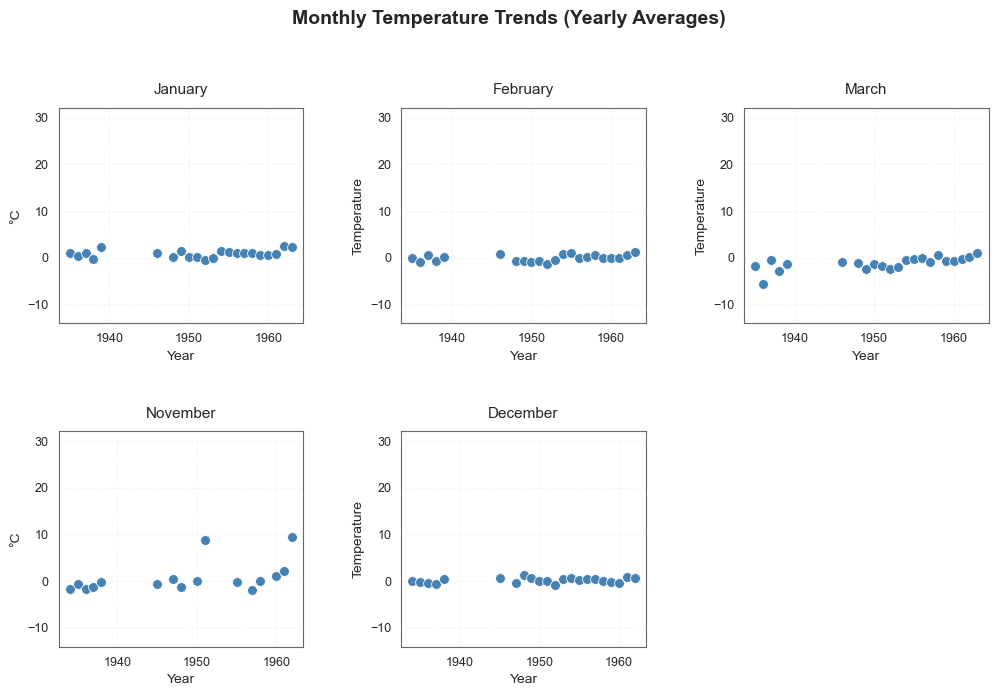

In [670]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Filter out April and October
valid_months = sorted(temp_df['month'].unique())
valid_months = [m for m in valid_months if m not in [4, 10] and 1 <= m <= 12]
n_months = len(valid_months)

# Calculate grid layout
n_cols = min(4, max(3, int(np.ceil(n_months**0.5))))
n_rows = int(np.ceil(n_months / n_cols))

# Create figure with adjusted spacing
fig, axes = plt.subplots(n_rows, n_cols, 
                        figsize=(4*n_cols, 3*n_rows + 1),
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.4})

if n_months > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Combine both datasets (assuming same temperature column name)
combined_df = pd.concat([
    temp_df[['year', 'month', 'Temp (air)']].rename(columns={'Temp (air)': 'Temperature'}),
    new_data_df_filtered[['year', 'month', 'Temp (air), C']].rename(columns={'Temp (air), C': 'Temperature'})
])

# Calculate y-axis limits from combined data
temp_range = combined_df['Temperature'].max() - combined_df['Temperature'].min()
y_min = combined_df['Temperature'].min() - 0.05 * temp_range
y_max = combined_df['Temperature'].max() + 0.05 * temp_range

# Plotting
for i, month in enumerate(valid_months):
    ax = axes[i]
    
    # Filter data for the month
    month_data = combined_df[combined_df['month'] == month]
    yearly_avg = month_data.groupby('year')['Temperature'].mean().reset_index()

    # Plot the combined data
    sns.scatterplot(data=yearly_avg, x='year', y='Temperature', 
                    color='steelblue', s=50, marker='o', edgecolor='white', ax=ax)

    # Styling
    ax.set_title(month_names[month-1], fontsize=11, pad=10)
    ax.set_ylim(y_min, y_max)
    ax.grid(True, linestyle=':', alpha=0.3)
    ax.tick_params(labelsize=9)
    ax.set_xlabel('Year', fontsize=10)
    if i % n_cols == 0:  # Only show y-label for leftmost plots
        ax.set_ylabel('°C', fontsize=10)

# Remove empty axes
for j in range(n_months, len(axes)):
    fig.delaxes(axes[j])

# Main title
plt.suptitle('Monthly Temperature Trends (Yearly Averages)', 
             y=1.02, fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(pad=3, h_pad=1.5, w_pad=1.5)

plt.show()


Using temperature columns: 'Temp (air)' (main) and 'Temp (air), C' (new)


<Figure size 1800x1200 with 0 Axes>

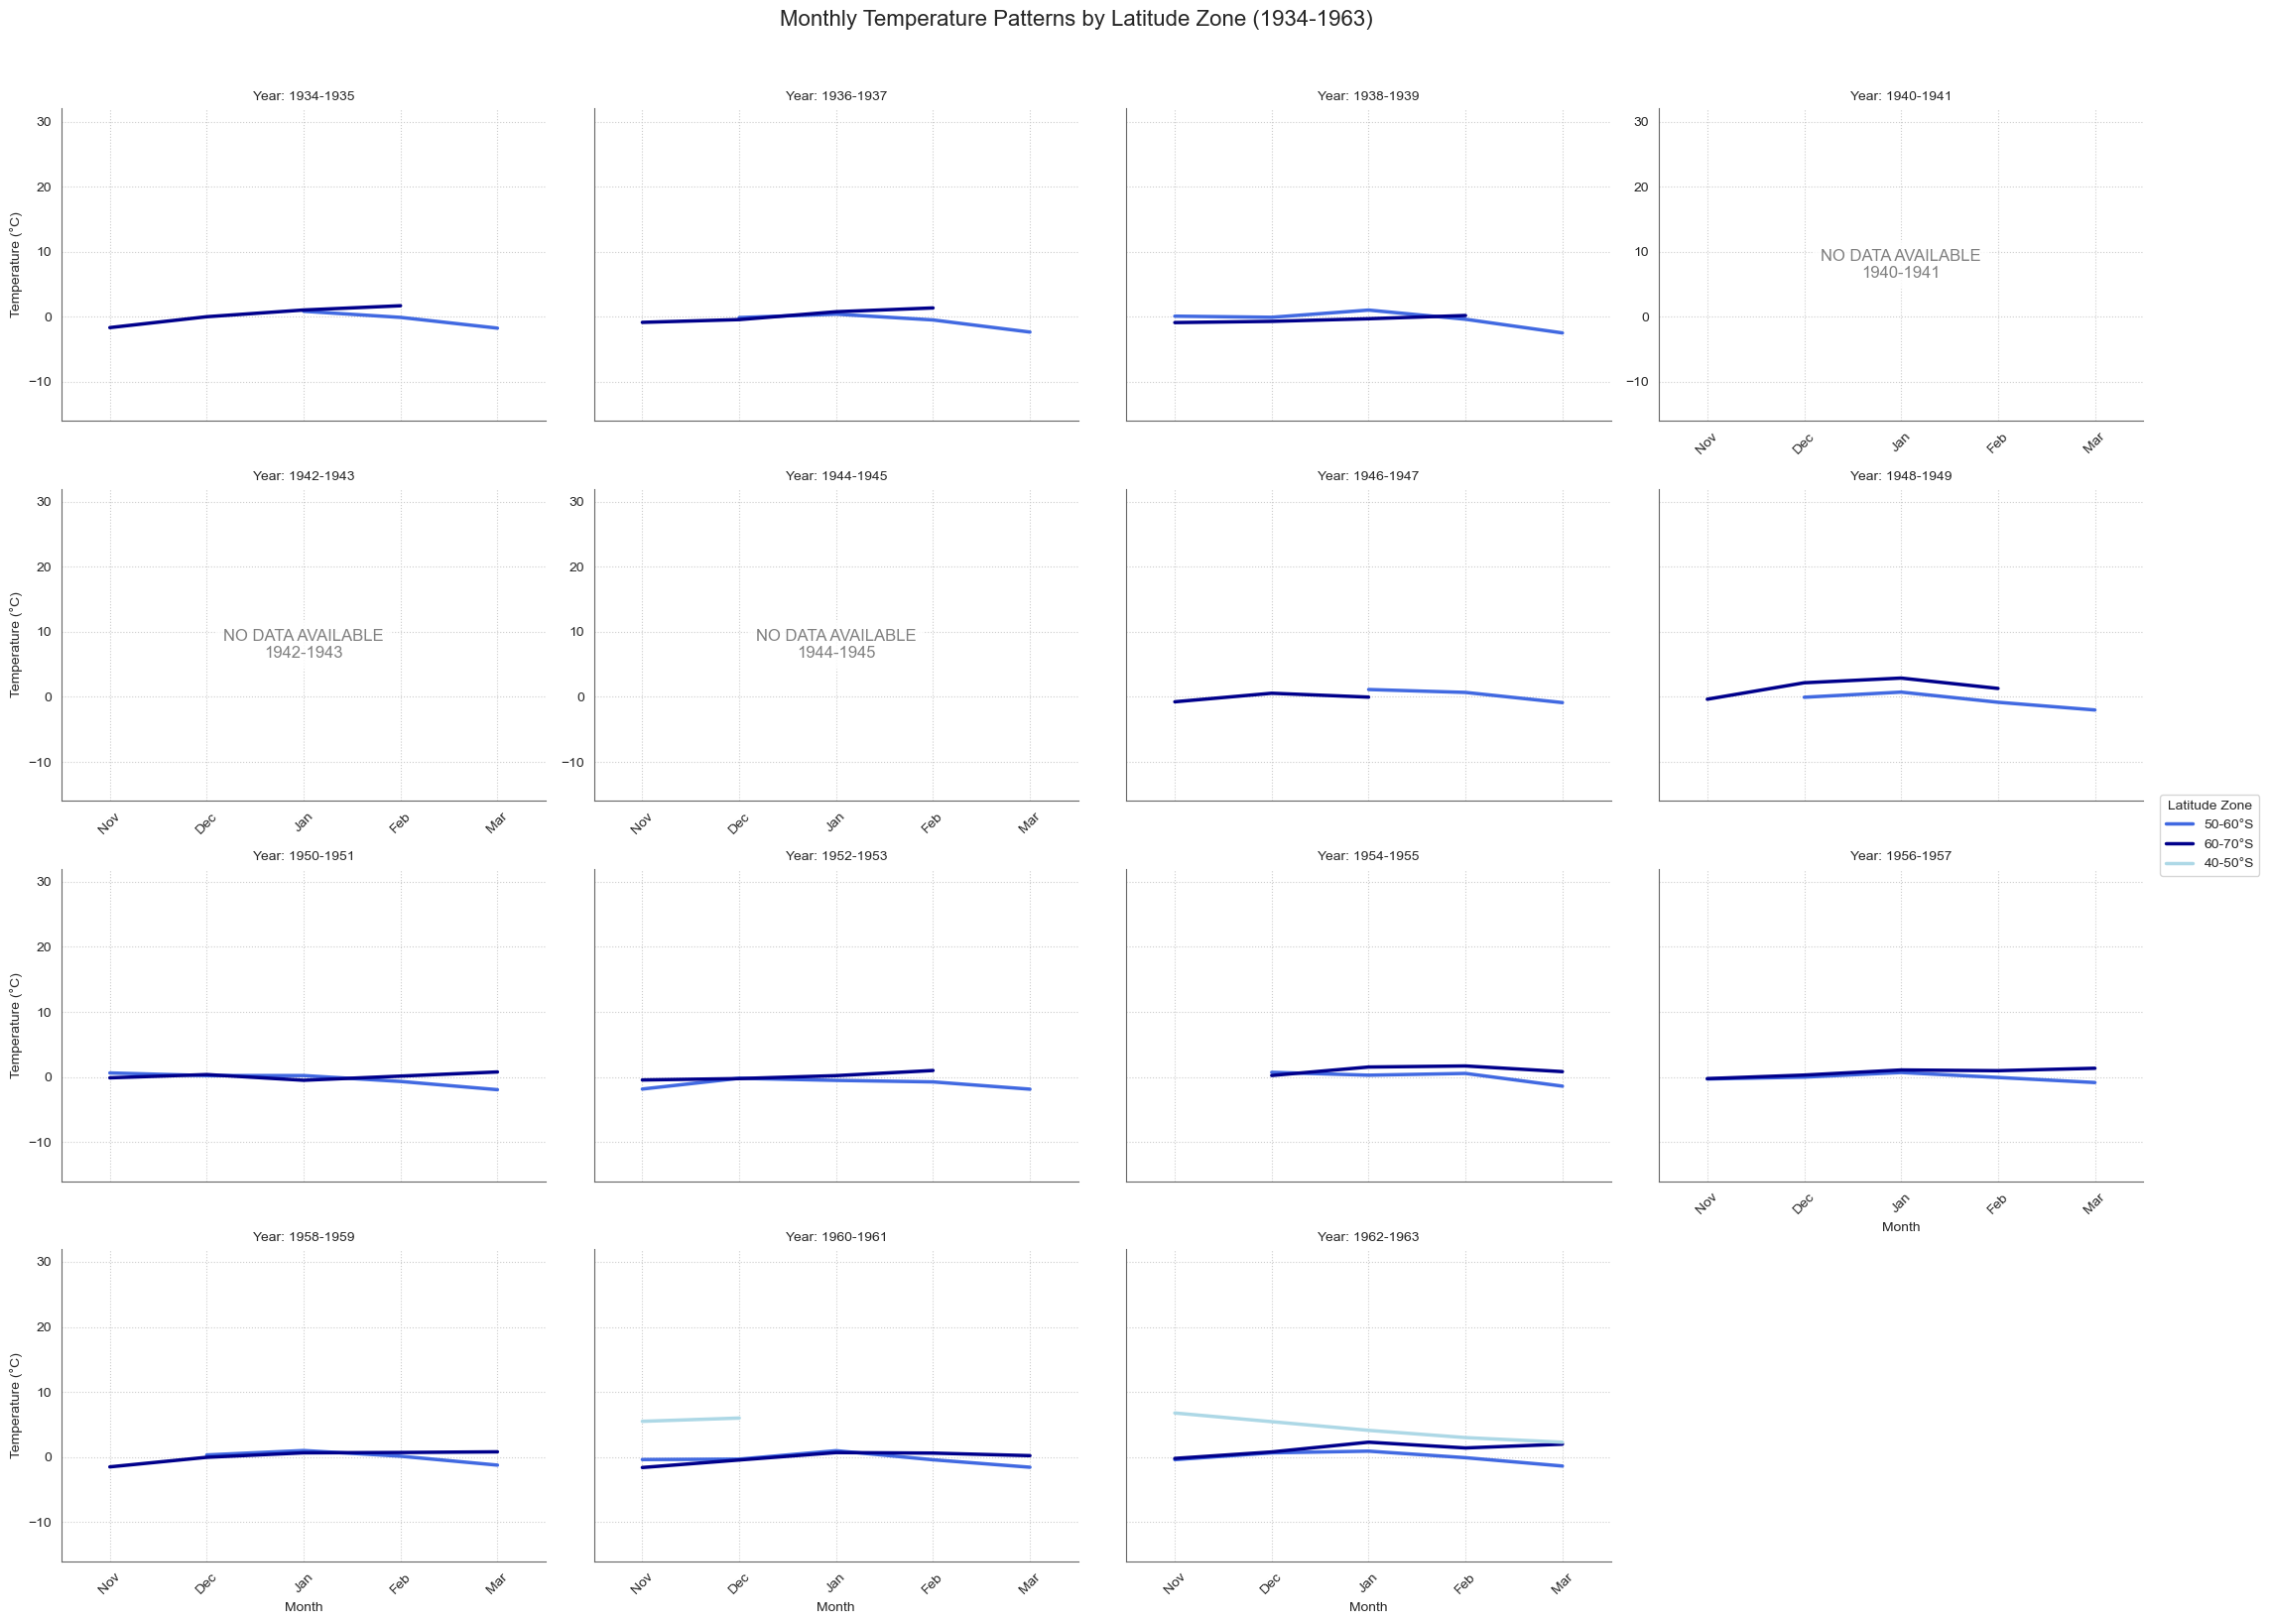

In [656]:


temp_col = find_temp_column(temp_df)
newdata_col = find_temp_column(new_data_df_filtered)
print(f"\nUsing temperature columns: '{temp_col}' (main) and '{newdata_col}' (new)")

# Create Latitude Zones 
lat_bins = [-70, -60, -50, -40]
lat_labels = ['50-60°S', '60-70°S', '40-50°S']

# Apply to both datasets
temp_df['lat_zone'] = pd.cut(temp_df['Latitude'], bins=lat_bins, labels=lat_labels)
new_data_df_filtered['lat_zone'] = pd.cut(new_data_df_filtered['Latitude'], bins=lat_bins, labels=lat_labels)

# Filter data for November to March 
temp_df['month'] = temp_df['date'].dt.month
temp_df['season_year'] = temp_df['year'].where(temp_df['month'] < 11, temp_df['year'] + 1)
temp_df_filtered = temp_df[(temp_df['month'].isin([11,12,1,2,3])) & (temp_df['year'] >= 1934)].copy()

new_data_df_filtered['month'] = new_data_df_filtered['date'].dt.month
new_data_df_filtered['season_year'] = new_data_df_filtered['year'].where(new_data_df_filtered['month'] < 11, new_data_df_filtered['year'] + 1)
new_data_df_filtered = new_data_df_filtered[(new_data_df_filtered['month'].isin([11,12,1,2,3])) & (new_data_df_filtered['year'] >= 1934)].copy()

# Create year groups
def format_year_group(year):
    base_year = int(year // 2 * 2)
    return f"{base_year}-{base_year + 1}"

temp_df_filtered['year_group'] = temp_df_filtered['season_year'].apply(format_year_group)
new_data_df_filtered['year_group'] = new_data_df_filtered['season_year'].apply(format_year_group)

# Adjust month numbering and keep names
month_map = {11:'Nov', 12:'Dec', 1:'Jan', 2:'Feb', 3:'Mar'}  # Changed to keep month names
temp_df_filtered['month_name'] = temp_df_filtered['month'].map(month_map)
new_data_df_filtered['month_name'] = new_data_df_filtered['month'].map(month_map)

# Create numeric month for ordering (1-5)
month_order = {11:1, 12:2, 1:3, 2:4, 3:5}
temp_df_filtered['month_num'] = temp_df_filtered['month'].map(month_order)
new_data_df_filtered['month_num'] = new_data_df_filtered['month'].map(month_order)

# Combine datasets
combined_df = pd.concat(
    [
        temp_df_filtered[['year', 'month_num', 'month_name', temp_col, 'lat_zone', 'year_group']]
            .rename(columns={temp_col: 'Temp (air)'}),
        new_data_df_filtered[['year', 'month_num', 'month_name', newdata_col, 'lat_zone', 'year_group']]
            .rename(columns={newdata_col: 'Temp (air)'})
    ], 
    ignore_index=True
)

# Create year group order 
all_years = range(1934, 1964, 2)
year_group_order = [f"{y}-{y+1}" for y in all_years]

# Create visualization
plt.figure(figsize=(18, 12))
sns.set_style("whitegrid", {'grid.linestyle': ':', 'axes.edgecolor': '0.4'})

custom_palette = {
    '50-60°S': 'Royalblue',
    '60-70°S': 'darkblue', 
    '40-50°S': 'lightblue'
}

g = sns.FacetGrid(
    combined_df,
    col='year_group',
    hue='lat_zone',
    col_wrap=4,
    height=4,
    aspect=1.3,
    palette=custom_palette,
    sharey=True,
    col_order=year_group_order
)

# Plot data using month_num for order but month_name for display
g.map(sns.lineplot, 'month_num', 'Temp (air)',
      estimator='mean',
      errorbar=None,
      linewidth=2.5,
      sort=True)

# Formatting
month_abbr = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']
y_min, y_max = combined_df['Temp (air)'].agg(['min', 'max'])
y_pad = (y_max - y_min) * 0.1
y_center = (y_min + y_max) / 2

for ax in g.axes.flat:
    ax.set_xticks(range(1, 6))
    ax.set_xticklabels(month_abbr, rotation=45)
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(y_min-y_pad, y_max+y_pad)
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, linestyle=':', color='0.8')

# Mark missing years
available_years = combined_df['year_group'].unique()
for ax, year in zip(g.axes.flat, g.col_names):
    if year not in available_years:
        ax.clear()
        ax.set_facecolor('white')
        ax.set_xticks(range(1, 6))
        ax.set_xticklabels(month_abbr, rotation=45)
        ax.set_ylim(y_min-y_pad, y_max+y_pad)
        ax.grid(True, linestyle=':', color='0.8')
        ax.text(3, y_center, 'NO DATA AVAILABLE\n' + year,
               ha='center', va='center', fontsize=12, color='gray',
               bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.5'))

g.set_axis_labels('Month', 'Temperature (°C)')
g.set_titles("Year: {col_name}", fontsize=11)
g.add_legend(title='Latitude Zone', bbox_to_anchor=(1.05, 0.5), frameon=True)
g.fig.suptitle('Monthly Temperature Patterns by Latitude Zone (1934-1963)', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

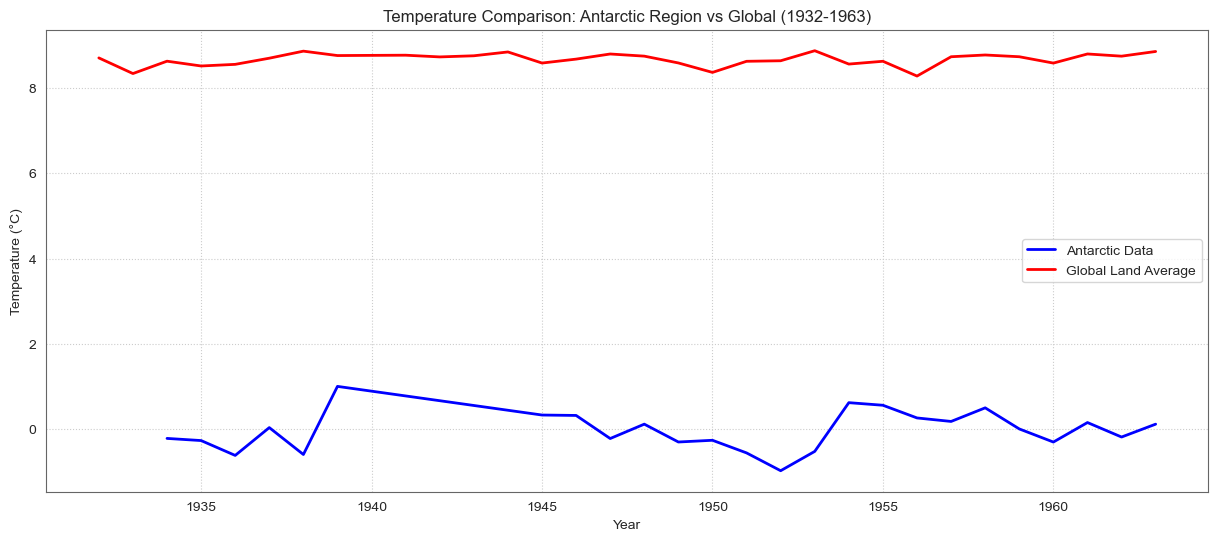

In [688]:
# Load and prepare whaling data
df_whaling = pd.read_excel('Bjorge_et_al_catchlogbook_whaling_weather_data_1932-63_data_publication (1).csv')
df_whaling['date'] = pd.to_datetime(df_whaling['date'])
df_whaling['Year'] = df_whaling['date'].dt.year
df_whaling = df_whaling[df_whaling['Latitude'] <= -55]  # Filter for Antarctic region

# Load global temperature data
df_global = pd.read_csv('GlobalTemperatures.csv', parse_dates=['dt'])
df_global['Year'] = df_global['dt'].dt.year
global_filtered = df_global[(df_global['Year'] >= 1932) & (df_global['Year'] <= 1963)]

# Prepare Antarctic data
new_data_filtered = new_data_df_filtered[(new_data_df_filtered['year'] >= 1932) & 
                                       (new_data_df_filtered['year'] <= 1963)]

# Combine Antarctic and whaling data 
combined_antarctic = pd.concat([
    df_whaling[['Year', 'Temp (air)']].rename(columns={'Year': 'year', 'Temp (air)': 'temperature'}),
    new_data_filtered[['year', 'Temp (air), C']].rename(columns={'Temp (air), C': 'temperature'})
])

# Calculate annual means
combined_annual = combined_antarctic.groupby('year')['temperature'].mean()
global_annual = global_filtered.groupby('Year')['LandAverageTemperature'].mean()

# Plot
plt.figure(figsize=(15, 6))
plt.plot(combined_annual.index, combined_annual.values, 
         'b-', linewidth=2, label='Antarctic Data')
plt.plot(global_annual.index, global_annual.values, 
         'r-', linewidth=2, label='Global Land Average')

plt.title('Temperature Comparison: Antarctic Region vs Global (1932-1963)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.show()